# Invoice PII redaction

## Technical details

- **OCR engine**: Uses Tesseract OCR via pytesseract
- **NER model**: spaCy's English model (en_core_web_sm)
- **Image processing**: OpenCV and PIL for image manipulation
- **PDF processing**: PyMuPDF (fitz) for native text extraction, pdf2image for OCR fallback
- **Redaction method**: Black rectangles drawn over detected text areas
- **Confidence filtering**: Only processes OCR text with >30% confidence
- **Duplicate removal**: Removes overlapping detections to avoid redundant redaction

## Limitations (can improve though)

- OCR accuracy depends on image quality and text clarity
- United States preference
- May occasionally miss context-specific personal information
- Bank account detection is based on number patterns and may have false positives
- Works best with standard invoice formats and clear text
- PDF processing can take time and might not work as well

### Requirements:
```bash
# Python packages
pip install pytesseract pillow opencv-python spacy ipywidgets matplotlib numpy PyPDF2 pdf2image pymupdf
python3 -m spacy download en_core_web_sm
```

**Requirements:**
- **Tesseract OCR**: Required for all OCR operations
  - Linux: `sudo apt-get install tesseract-ocr`
  - mac: `brew install tesseract`
  
- **poppler-utils**: Required for PDF visual redaction
  - Linux: `sudo apt-get install poppler-utils`
  - mac: `brew install poppler`

In [186]:
import re
import cv2
import numpy as np
import pytesseract
import spacy
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict, Any

# PDF processing libraries
import pdf2image
import fitz  # PyMuPDF

# Load spaCy model for named entity recognition
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy model not found. Please run: python -m spacy download en_core_web_sm")

### Text extraction, this gives all the text boxes in the file. These text boxes are used for every other PII extraction

In [189]:
def extract_text_with_boxes(image_path):
    """
    Extract text from image using OCR with bounding box coordinates.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        List[Dict]: List of dictionaries containing text and bounding box coordinates
    """
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert to RGB (pytesseract expects RGB)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Try different OCR configurations
        configs = [
            '--psm 6',  # Uniform block of text
            '--psm 11',  # Sparse text
            '--psm 3',   # Fully automatic page segmentation
        ]
        
        all_text_boxes = []
        
        for config in configs:
            try:
                # Get OCR data with this configuration
                ocr_data = pytesseract.image_to_data(image_rgb, config=config, output_type=pytesseract.Output.DICT)
                
                # Extract text with bounding boxes
                for i in range(len(ocr_data['text'])):
                    text = ocr_data['text'][i].strip()
                    conf = int(ocr_data['conf'][i])
                    
                    # Lower confidence threshold for better extraction
                    if text and conf > 25:
                        x = ocr_data['left'][i]
                        y = ocr_data['top'][i]
                        w = ocr_data['width'][i]
                        h = ocr_data['height'][i]
                        
                        # Check if we already have this text box (avoid duplicates)
                        duplicate = False
                        for existing_box in all_text_boxes:
                            if (text == existing_box['text'] and 
                                abs(x - existing_box['bbox'][0]) < 10 and 
                                abs(y - existing_box['bbox'][1]) < 10):
                                duplicate = True
                                break
                        
                        if not duplicate:
                            all_text_boxes.append({
                                'text': text,
                                'bbox': (x, y, x + w, y + h),
                                'confidence': conf
                            })
            except Exception as e:
                continue
        
        return all_text_boxes
    
    except Exception as e:
        print(f"Error extracting text: {str(e)}")
        return []

### Name extraction using NER/Spacy

In [188]:
def detect_names(text_boxes):
    """
    Detect person names using spaCy NER.
    
    Args:
        text_boxes (List[Dict]): List of text boxes with OCR data
        
    Returns:
        List[Dict]: List of detected name boxes
    """
    name_boxes = []
    
    # Combine all text for NER processing
    full_text = " ".join([box['text'] for box in text_boxes])
    doc = nlp(full_text)
    
    # Find person entities
    person_names = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    
    # Match names back to bounding boxes
    for name in person_names:
        for box in text_boxes:
            if name.lower() in box['text'].lower() or box['text'].lower() in name.lower():
                name_boxes.append({
                    'text': box['text'],
                    'bbox': box['bbox'],
                    'type': 'name',
                    'detected_entity': name
                })
    
    return name_boxes

### Address extraction (Custom for United States. PS: most time consuming in terms of building this notebook)
- Checks if address groups exist
- Checks if groups are close to each other or in the same line so that they can be redacted in a group

In [187]:
def detect_addresses(text_boxes):
    """
    Improved address detection that captures complete addresses using spatial proximity.
    Includes business data preservation to avoid redacting legitimate business information.
    
    Args:
        text_boxes (List[Dict]): List of text boxes with OCR data
        
    Returns:
        List[Dict]: List of detected address boxes
    """
    address_keywords = [
        'street', 'st', 'avenue', 'ave', 'road', 'rd', 'drive', 'dr',
        'boulevard', 'blvd', 'lane', 'ln', 'court', 'ct', 'place', 'pl'
    ]
    
    us_states = {
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
    }
    
    def is_business_data(text):
        """Check if text represents business data that should NOT be redacted"""
        text_lower = text.lower()
        
        # Business terms that should be preserved
        business_terms = [
            'quantity', 'qty', 'price', 'amount', 'total', 'subtotal', 'tax', 'cost',
            'days', 'weeks', 'months', 'hours', 'rate', 'per', 'each', 'unit',
            'foundation', 'work', 'steel', 'structure', 'installation', 'concrete', 
            'material', 'structural', 'construction', 'invoice', 'number', 'date', 
            'due', 'payment', 'grand', 'cubics', 'tons', 'description', 'services'
        ]
        
        if any(term in text_lower for term in business_terms):
            return True
        
        # Preserve monetary values
        if re.search(r'[$€£¥]\d+|^\d+\.\d+$|^\d+,\d+$', text):
            return True
        
        # Preserve small quantities
        if re.match(r'^\d{1,3}$', text) and int(text) <= 999:
            return True
        
        return False
    
    def is_address_component(text):
        """Check if text could be part of an address (not business data)"""
        text_lower = text.lower()
        
        # Don't consider business terms as addresses
        if is_business_data(text):
            return False
        
        return (
            # Street numbers (only if not business data)
            (text.isdigit() and 1 <= len(text) <= 5) or
            # Street names
            any(keyword in text_lower for keyword in address_keywords) or
            # State abbreviations
            text.upper() in us_states or
            # Cities (ending with comma)
            text.endswith(',') or
            # ZIP codes
            re.match(r'^\d{5}(?:-\d{4})?$', text)
        )
    
    def boxes_are_nearby(box1, box2, max_distance=100):
        """Check if two boxes are close enough to be part of the same address"""
        b1_center_x = (box1['bbox'][0] + box1['bbox'][2]) / 2
        b1_center_y = (box1['bbox'][1] + box1['bbox'][3]) / 2
        b2_center_x = (box2['bbox'][0] + box2['bbox'][2]) / 2
        b2_center_y = (box2['bbox'][1] + box2['bbox'][3]) / 2
        
        distance = ((b1_center_x - b2_center_x)**2 + (b1_center_y - b2_center_y)**2)**0.5
        return distance <= max_distance
    
    def same_line(box1, box2, tolerance=15):
        """Check if two boxes are on the same horizontal line"""
        b1_center_y = (box1['bbox'][1] + box1['bbox'][3]) / 2
        b2_center_y = (box2['bbox'][1] + box2['bbox'][3]) / 2
        return abs(b1_center_y - b2_center_y) <= tolerance
    
    # Find potential address components, excluding business data
    address_components = []
    for box in text_boxes:
        if is_address_component(box['text']):
            address_components.append(box)
    
    # Group components into addresses
    address_groups = []
    used_components = set()
    
    for comp in address_components:
        if id(comp) in used_components:
            continue
            
        # Start a new group with this component
        group = [comp]
        used_components.add(id(comp))
        
        # Find other components that should be grouped with this one
        for other_comp in address_components:
            if id(other_comp) in used_components:
                continue
                
            # Check if they're close enough and on same line or very close vertically
            if (boxes_are_nearby(comp, other_comp, max_distance=200) and
                (same_line(comp, other_comp) or 
                 abs((comp['bbox'][1] + comp['bbox'][3])/2 - (other_comp['bbox'][1] + other_comp['bbox'][3])/2) <= 25)):
                group.append(other_comp)
                used_components.add(id(other_comp))
        
        # Only create address if we have multiple components
        if len(group) >= 2:
            # Sort by reading order (top to bottom, left to right)
            group.sort(key=lambda b: (b['bbox'][1], b['bbox'][0]))
            
            # Calculate encompassing bounding box
            min_x = min(box['bbox'][0] for box in group)
            min_y = min(box['bbox'][1] for box in group)
            max_x = max(box['bbox'][2] for box in group)
            max_y = max(box['bbox'][3] for box in group)
            
            # Combine text
            combined_text = ' '.join(box['text'] for box in group)
            
            address_groups.append({
                'text': combined_text,
                'bbox': (min_x, min_y, max_x, max_y),
                'type': 'address',
                'components': len(group)
            })
    
    return address_groups

### Phone number detection, again custom for US for now

In [190]:
def detect_phone_numbers(text_boxes):
    """
    Detect phone numbers using regex patterns.
    
    Args:
        text_boxes (List[Dict]): List of text boxes with OCR data
        
    Returns:
        List[Dict]: List of detected phone number boxes
    """
    phone_patterns = [
        r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b',  # 123-456-7890 or 123.456.7890 or 1234567890
        r'\(\d{3}\)\s?\d{3}[-.]?\d{4}\b',  # (123) 456-7890
        r'\b1[-.]?\d{3}[-.]?\d{3}[-.]?\d{4}\b',  # 1-123-456-7890
        r'\+1[-.]?\d{3}[-.]?\d{3}[-.]?\d{4}\b'  # +1-123-456-7890
    ]
    
    phone_boxes = []
    
    for box in text_boxes:
        for pattern in phone_patterns:
            if re.search(pattern, box['text']):
                phone_boxes.append({
                    'text': box['text'],
                    'bbox': box['bbox'],
                    'type': 'phone'
                })
                break
    
    return phone_boxes

### Bank accounts detection using earlier text boxes. Only takes 8-20 digit sequences using regex

In [191]:
def detect_bank_accounts(text_boxes):
    """
    Detect bank account numbers using regex patterns.
    
    Args:
        text_boxes (List[Dict]): List of text boxes with OCR data
        
    Returns:
        List[Dict]: List of detected bank account boxes
    """
    # Various bank account patterns
    bank_patterns = [
        r'\b\d{3}-\d{3}-\d{3}\b',  # 123-456-789
        r'\b\d{8,20}\b',  # 8-20 digit sequences
        r'\b\d{4}\s\d{4}\s\d{4}\s\d{4}\b',  # 1234 5678 9012 3456
        r'\b\d{4}-\d{4}-\d{4}-\d{4}\b'  # 1234-5678-9012-3456
    ]
    
    bank_boxes = []
    
    for box in text_boxes:
        text = box['text']
        
        # Check each pattern
        for pattern in bank_patterns:
            if re.search(pattern, text):
                bank_boxes.append({
                    'text': text,
                    'bbox': box['bbox'],
                    'type': 'bank_account'
                })
                break
        
        # Also check for context-based detection
        text_lower = text.lower()
        context_keywords = ['account', 'acct', 'bank', 'routing', 'aba']
        
        if any(keyword in text_lower for keyword in context_keywords):
            # Look for numbers in this text
            numbers = re.findall(r'\d+', text)
            if any(len(num) >= 6 for num in numbers):
                bank_boxes.append({
                    'text': text,
                    'bbox': box['bbox'],
                    'type': 'bank_account'
                })
    
    return bank_boxes

### Email detection using regex

In [193]:
def detect_emails(text_boxes):
    """
    Detect email addresses using regex patterns.
    
    Args:
        text_boxes (List[Dict]): List of text boxes with OCR data
        
    Returns:
        List[Dict]: List of detected email boxes
    """
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    
    email_boxes = []
    
    for box in text_boxes:
        if re.search(email_pattern, box['text']):
            email_boxes.append({
                'text': box['text'],
                'bbox': box['bbox'],
                'type': 'email'
            })
    
    return email_boxes

### Helper function to redact individual text boxes which are detected for redaction

In [192]:
def redact_image(image_path, pii_boxes):
    """
    Redact personal information by drawing black rectangles over detected areas.
    
    Args:
        image_path (str): Path to the original image
        pii_boxes (List[Dict]): List of PII detection boxes to redact
        
    Returns:
        np.ndarray: Redacted image as numpy array
    """
    try:
        # Load the original image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert to RGB for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw black rectangles over detected PII
        for box in pii_boxes:
            x1, y1, x2, y2 = box['bbox']
            # Add some padding to ensure complete coverage
            padding = 2
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(image_rgb.shape[1], x2 + padding)
            y2 = min(image_rgb.shape[0], y2 + padding)
            
            # Draw black rectangle
            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 0, 0), -1)
        
        return image_rgb
    
    except Exception as e:
        print(f"Error redacting image: {str(e)}")
        return None

### This is where all the text boxes detected for redaction in the invoices are redacted using the above function.

In [194]:
def process_invoice(image_path: str) -> Tuple[np.ndarray, Dict[str, int]]:
    """
    Main function to process an invoice image and redact personal information.
    
    Args:
        image_path (str): Path to the invoice image
        
    Returns:
        Tuple[np.ndarray, Dict]: Redacted image and statistics
    """
    print("Extracting text from image...")
    text_boxes = extract_text_with_boxes(image_path)
    
    if not text_boxes:
        print("No text found in image")
        return None, {}

    name_boxes = detect_names(text_boxes)
    address_boxes = detect_addresses(text_boxes)
    phone_boxes = detect_phone_numbers(text_boxes)
    bank_boxes = detect_bank_accounts(text_boxes)
    email_boxes = detect_emails(text_boxes)
    
    # Combine all PII detections
    all_pii_boxes = name_boxes + address_boxes + phone_boxes + bank_boxes + email_boxes
    
    # Remove duplicates based on bounding box overlap
    unique_pii_boxes = []
    for box in all_pii_boxes:
        is_duplicate = False
        for existing_box in unique_pii_boxes:
            # Check for significant overlap
            x1, y1, x2, y2 = box['bbox']
            ex1, ey1, ex2, ey2 = existing_box['bbox']
            
            # Calculate overlap
            overlap_x = max(0, min(x2, ex2) - max(x1, ex1))
            overlap_y = max(0, min(y2, ey2) - max(y1, ey1))
            overlap_area = overlap_x * overlap_y
            
            box_area = (x2 - x1) * (y2 - y1)
            existing_area = (ex2 - ex1) * (ey2 - ey1)
            
            if overlap_area > 0.5 * min(box_area, existing_area):
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_pii_boxes.append(box)
    
    # Statistics
    stats = {
        'names': len(name_boxes),
        'addresses': len(address_boxes),
        'phones': len(phone_boxes),
        'bank_accounts': len(bank_boxes),
        'emails': len(email_boxes),
        'total_redacted': len(unique_pii_boxes)
    }
    
    redacted_image = redact_image(image_path, unique_pii_boxes)
    
    return redacted_image, stats

In [173]:
def display_results(original_path: str, redacted_image: np.ndarray, stats: Dict[str, int]):
    """
    Display the original and redacted images side by side.
    
    Args:
        original_path (str): Path to original image
        redacted_image (np.ndarray): Redacted image array
        stats (Dict): Detection statistics
    """
    try:
        # Load original image
        original = cv2.imread(original_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Create side-by-side comparison
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Original image
        ax1.imshow(original_rgb)
        ax1.set_title('Original Invoice', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Redacted image
        ax2.imshow(redacted_image)
        ax2.set_title('Redacted Invoice', fontsize=14, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error displaying results: {str(e)}")

### End user function to return original and redacted invoices side by side

In [195]:
def process_invoice_from_path(image_path: str):
    """
    Process an invoice from a file path and display results.
    
    Args:
        image_path (str): Path to the invoice image file
    """
    print(f"Processing: {image_path}")
    print("=" * 50)
    
    # Process the invoice
    redacted_image, stats = process_invoice(image_path)
    
    if redacted_image is not None:
        print("\nRedaction completed successfully!")
        display_results(image_path, redacted_image, stats)
    else:
        print("Failed to process the invoice")

### Adding functionality to redact pdfs
- Using poppler OCR for detection
- Functionality similar to images

In [175]:
def detect_file_type(file_path: str) -> str:
    """
    Detect if the file is a PDF or image based on extension.
    
    Args:
        file_path: Path to the file
        
    Returns:
        'pdf' or 'image'
    """
    extension = os.path.splitext(file_path)[1].lower()
    if extension == '.pdf':
        return 'pdf'
    elif extension in ['.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif']:
        return 'image'
    else:
        raise ValueError(f"Unsupported file type: {extension}")

#### Extracts text from pdf using ocr

In [196]:
def extract_text_from_pdf_ocr(pdf_path):
    """
    Extract text from PDF by converting to images and using OCR.
    This method works for both text-based and image-based PDFs.
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        List of text boxes with coordinates
    """
    try:
        # Convert PDF pages to images
        images = pdf2image.convert_from_path(pdf_path, dpi=300)
        
        all_text_boxes = []
        
        for page_num, image in enumerate(images):
            # Convert PIL image to OpenCV format
            image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
            
            # Use our existing OCR function
            temp_path = f"temp_page_{page_num}.png"
            cv2.imwrite(temp_path, image_cv)
            
            # Extract text using our improved OCR
            page_text_boxes = extract_text_with_boxes(temp_path)
            
            # Add page number to each text box
            for box in page_text_boxes:
                box['page'] = page_num + 1
            
            all_text_boxes.extend(page_text_boxes)
            
            # Clean up temporary file
            try:
                os.remove(temp_path)
            except:
                pass
        
        return all_text_boxes
        
    except Exception as e:
        print(f"Error extracting text from PDF: {str(e)}")
        return []

#### Extracting text without ocr. Does not work that well

In [197]:
def extract_text_from_pdf_native(pdf_path):
    """
    Extract text from PDF using native text extraction (faster for text-based PDFs).
    
    Args:
        pdf_path: Path to the PDF file
        
    Returns:
        List of text boxes with coordinates
    """
    try:
        doc = fitz.open(pdf_path)
        all_text_boxes = []
        
        for page_num in range(len(doc)):
            page = doc[page_num]
            
            # Get text with bounding boxes
            text_dict = page.get_text("dict")
            
            for block in text_dict["blocks"]:
                if "lines" in block:
                    for line in block["lines"]:
                        for span in line["spans"]:
                            text = span["text"].strip()
                            if text:
                                bbox = span["bbox"]  # (x0, y0, x1, y1)
                                all_text_boxes.append({
                                    'text': text,
                                    'bbox': (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])),
                                    'confidence': 100,  # Native text extraction has high confidence
                                    'page': page_num + 1
                                })
        
        doc.close()
        return all_text_boxes
        
    except Exception as e:
        print(f"Error with native PDF text extraction: {str(e)}")
        return []

### Function to redact PII in pdfs

In [ ]:
def process_pdf_invoice(pdf_path, use_ocr: bool = False):
    """
    Process a PDF invoice and redact personal information.
    
    Args:
        pdf_path: Path to the PDF file
        use_ocr: If True, use OCR method; if False, try native text extraction first
        
    Returns:
        Tuple of (list of redacted page images, statistics)
    """
    print(f"Processing PDF: {pdf_path}")
    print("=" * 50)
    
    # Extract text from PDF
    if use_ocr:
        text_boxes = extract_text_from_pdf_ocr(pdf_path)
    else:
        text_boxes = extract_text_from_pdf_native(pdf_path)
        
        # If native extraction didn't work well, fall back to OCR
        if len(text_boxes) < 10:  # Arbitrary threshold
            text_boxes = extract_text_from_pdf_ocr(pdf_path)
    
    if not text_boxes:
        return [], {}
    
    # Group text boxes by page
    pages_text = {}
    for box in text_boxes:
        page_num = box.get('page', 1)
        if page_num not in pages_text:
            pages_text[page_num] = []
        pages_text[page_num].append(box)
    
    # Process each page
    redacted_pages = []
    total_stats = {
        'names': 0,
        'addresses': 0,
        'phones': 0,
        'bank_accounts': 0,
        'emails': 0,
        'total_redacted': 0
    }
    
    # Convert PDF pages to images for redaction
    images = pdf2image.convert_from_path(pdf_path, dpi=300)
    
    for page_num, image in enumerate(images, 1):
        page_text_boxes = pages_text.get(page_num, [])
        
        if not page_text_boxes:
            # No text on this page, just convert to numpy array
            redacted_pages.append(np.array(image))
            continue
        
        # Detect PII on this page
        name_boxes = detect_names(page_text_boxes)
        address_boxes = detect_addresses(page_text_boxes)
        phone_boxes = detect_phone_numbers(page_text_boxes)
        bank_boxes = detect_bank_accounts(page_text_boxes)
        email_boxes = detect_emails(page_text_boxes)
        
        # Combine all PII detections
        all_pii_boxes = name_boxes + address_boxes + phone_boxes + bank_boxes + email_boxes
        
        # Remove duplicates
        unique_pii_boxes = []
        for box in all_pii_boxes:
            is_duplicate = False
            for existing_box in unique_pii_boxes:
                x1, y1, x2, y2 = box['bbox']
                ex1, ey1, ex2, ey2 = existing_box['bbox']
                
                overlap_x = max(0, min(x2, ex2) - max(x1, ex1))
                overlap_y = max(0, min(y2, ey2) - max(y1, ey1))
                overlap_area = overlap_x * overlap_y
                
                box_area = (x2 - x1) * (y2 - y1)
                existing_area = (ex2 - ex1) * (ey2 - ey1)
                
                if overlap_area > 0.5 * min(box_area, existing_area):
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                unique_pii_boxes.append(box)
        
        # Update statistics
        total_stats['names'] += len(name_boxes)
        total_stats['addresses'] += len(address_boxes)
        total_stats['phones'] += len(phone_boxes)
        total_stats['bank_accounts'] += len(bank_boxes)
        total_stats['emails'] += len(email_boxes)
        total_stats['total_redacted'] += len(unique_pii_boxes)
        
        # Redact the page image
        image_array = np.array(image)
        
        # Draw black rectangles over detected PII
        for box in unique_pii_boxes:
            x1, y1, x2, y2 = box['bbox']
            # Add padding
            padding = 2
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(image_array.shape[1], x2 + padding)
            y2 = min(image_array.shape[0], y2 + padding)
            
            # Draw black rectangle
            cv2.rectangle(image_array, (x1, y1), (x2, y2), (0, 0, 0), -1)
        
        redacted_pages.append(image_array)
    
    return redacted_pages, total_stats

### Function to display pdf results

In [198]:
def display_pdf_results(pdf_path, redacted_pages):
    """
    Display original and redacted PDF pages side by side.
    """
    try:
        # Load original pages
        original_images = pdf2image.convert_from_path(pdf_path, dpi=300)
        
        # Display each page
        for page_num, (original, redacted) in enumerate(zip(original_images, redacted_pages), 1):
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
            
            # Original page
            ax1.imshow(original)
            ax1.set_title(f'Original Invoice - Page {page_num}', fontsize=14, fontweight='bold')
            ax1.axis('off')
            
            # Redacted page
            ax2.imshow(redacted)
            ax2.set_title(f'Redacted Invoice - Page {page_num}', fontsize=14, fontweight='bold')
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error displaying PDF results: {str(e)}")

### End user function to redact pdfs

In [180]:
def process_invoice_universal(file_path: str, use_ocr_for_pdf: bool = False):
    """
    Universal function to process both PDF and image invoices.
    
    Args:
        file_path: Path to the invoice file (PDF or image)
        use_ocr_for_pdf: If True, use OCR for PDFs; if False, try native text extraction first
    """
    try:
        file_type = detect_file_type(file_path)
        
        if file_type == 'pdf':
            redacted_pages, stats = process_pdf_invoice(file_path, use_ocr_for_pdf)
            if redacted_pages:
                print("\nPDF redaction completed successfully!")
                display_pdf_results(file_path, redacted_pages, stats)
            else:
                print("Failed to process the PDF")
        else:
            # Use existing image processing function
            redacted_image, stats = process_invoice(file_path)
            if redacted_image is not None:
                print("\nImage redaction completed successfully!")
                display_results(file_path, redacted_image, stats)
            else:
                print("Failed to process the image")
    
    except Exception as e:
        print(f"Error processing file: {str(e)}")

## Usage examples

### Image processing
```python
# Process a PNG invoice image
process_invoice_from_path('invoice-sample-1.png')
```

### PDF processing
```python
# Process a PDF invoice (uses native text extraction first)
process_invoice_universal('invoice-sample-5.pdf')
```

### Using OCR for PDF (recommended)
```python
# Force OCR processing for PDFs (useful for image-based PDFs)
process_invoice_universal('invoice-sample-5.pdf', use_ocr_for_pdf=True)
```


Processing: invoice-sample-1.png
Extracting text from image...

Redaction completed successfully!


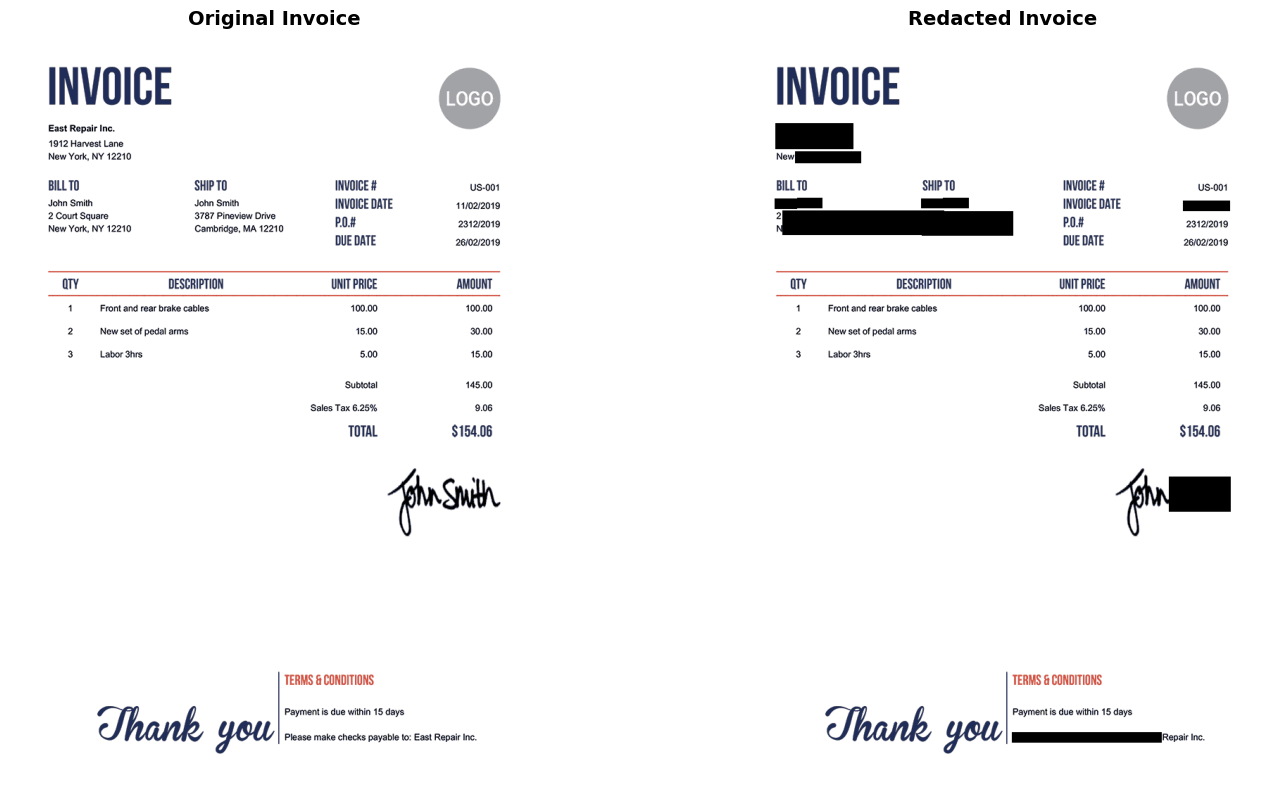

In [212]:
process_invoice_from_path('invoice-sample-1.png')